# World Data League 2021

## External links and resources

### External Data

Source for weather data : https://www.worldweatheronline.com/developer/

Medellin weather data : https://drive.google.com/file/d/1rsHkSdBCgKjr26V71c7jop3Ak-dcBlc7/view?usp=sharing

### Support Document

NOTE: Due to some issues we found when running this notebook, it may happen that the interactive graphs drawn by the **folium** and **seaborn** library will not appear. In order to see a static version of these graphs, you can check the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing

## Introduction


Our idea for this challeng was to try and provide actionable insights to the people responsible for distributing the bikes by the different stations. Our teams' experience with similar systems of bycicles in different cities was that the bycicleass are normally moved between stations at night. Because of that, our idea was then to provide insights on a daily basis.

In order to provide these insights, we aggregate the data and make predictions on a daily basis, for each station. More specifically, we are trying to predict the **daily** 'flow' or 'deficit'(difference between demand and supply) of vehicles in each station, and are proposing a strategy for **static repositioning** of vehicles. By means of this strategy, based on the predicted demand for the next day, we would redistribute vehicles, **each night**, from stations that have surplus vehicles to those that are expected to run short of bikes to meet the daily demand. 

In this notebook, we have performed some EDA, and have built a baseline model to predict the daily flow of vehicles in each station. We are also using the city weather data as an additional feature to enhance the baseline model. 

We have also proposed a redistribution algorithm, which, given the forecasts for the next day, would automatically give us the allocation/distribution values for vehicles, from stations of excess to stations of deficit.

Given the allocation values for each station, the admins of the city bike sharing system will be charged with the responsibility of actually transporting the vehicles from one station to another. This transportation should be done once a day, preferably at night, when there would be less usage of bikes.

## Development


# **Importing Libraries**

In [1]:
!pip install geopandas folium wwo-hist haversine -q

In [2]:
import pandas as pd
import numpy as np
import requests, zipfile, io
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, date, datetime
import geopandas as gpd
from wwo_hist import retrieve_hist_data
from haversine import haversine, Unit
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

#import openweather
import fiona
import os
import sys
import folium
import warnings

warnings.simplefilter(action='ignore')

import requests
import shapely

from zipfile import ZipFile

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# **Functions**

In [55]:
def add_lags_diffs(df, date_column, element_colum, prediction_column, n_lag_days = 3):
    df = df.sort_values(date_column)
    df['Previous_day_flow'] = df.groupby([element_colum])[prediction_column].shift()
    
    for i in range(1,n_lag_days+1):
        df[f'Last-{i}_Day_{prediction_column}'] = df.groupby([element_colum])[prediction_column].shift(i+1)
        df[f'Last-{i}_Day_Diff'] = df.groupby([element_colum])[f'Last-{i}_Day_{prediction_column}'].diff()
        
    df = df.dropna()
    return df

def _weather_pd(url):
    url_df = requests.get(weather_req_url).json()
    df1 = pd.json_normalize(url_df['list'], 'weather')
    df2 = pd.json_normalize(url_df['list'])
    df = df2.drop('weather', axis=1).join(df1)
    return df

def treat_lat_lon (df, lat_col, lon_col):
    df[lat_col] = df[lat_col].str.replace(',', '.')
    df[lat_col] = df[lat_col].astype(float)
    df[lon_col] = df[lon_col].str.replace(',', '.')
    df[lon_col] = df[lon_col].astype(float)
    return df

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def pd_distance(loc1, loc2):
    '''
    This function takes single row pandas df (which contains only two columns lat and long)
    And takes another single row pandas df (as specified)
    Converts them to tuples
    And calculates haversine distance

    Haversine distance is a geological distance between two lattitudes and longitudes, 
    as measured on earth's surface
    '''
    # distance when loc1 and loc2 are pandas df rows, tho single row
    return haversine(tuple(loc1.values),tuple(loc2.values))

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def rf_model (n_trees = 1000):
    mean_error = []
    for day in daterange(start_date, end_date):
        train = whole_dataset[(whole_dataset['loan_date'] < day) & (whole_dataset['loan_date'] > cutoff_date)]
        # validation set is only current day
        val = whole_dataset[whole_dataset['loan_date'] == day]
    
        xtr, xts = train.drop(['flow', 'loan_date'], axis=1), val.drop(['flow', 'loan_date'], axis=1)
        ytr, yts = train['flow'].values, val['flow'].values
    
        mdl = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
        try:
            p = mdl.predict(xts)
        except:
            continue
        
        error = rmse(yts, p)
        
        #print(f'Day {str(day)[:10]} - Error {error}')
        mean_error.append(error)
    print(' Random Forest Mean Error = %.5f' % np.mean(mean_error))
    return p, mdl

def lgb_model(n_preds = 1000):
    mean_error = []
    for day in daterange(start_date, end_date):
        train = whole_dataset[(whole_dataset['loan_date'] < day) & (whole_dataset['loan_date'] > cutoff_date)]
        # validation set is only current day
        val = whole_dataset[whole_dataset['loan_date'] == day]

        xtr, xts = train.drop(['flow', 'loan_date'], axis=1), val.drop(['flow', 'loan_date'], axis=1)
        ytr, yts = train['flow'].values, val['flow'].values

        mdl = LGBMRegressor(n_estimators=n_preds, learning_rate=0.01)
        mdl.fit(xtr, ytr, categorical_feature ='auto')
        try:
            p = mdl.predict(xts)
        except:
            continue

        error = rmse(yts, p)
        #print(f'Day {str(day)[:10]} - Error {error}')
        mean_error.append(error)
    print('LightGBM Mean Error = %.5f' % np.mean(mean_error))
    return p, mdl

def basic_distribute(surplus_station_id, df):
    '''
    Baseline
    Function to distribute surplus demand of a single station, to all other deficit stations
    Takes into consideration - only demand
    '''
    # Takes a station id (surplus)
    # Filters df to get it's surplus demand
    # Filters df to get deficit demand stations data
    # Returns a data-frame with station_id, 
    # and demand to be transfered to that station_id (from surplus station)
    
    # Surplus station demand, to be distributed
    surplus_station_demand = df[df['station_id']==surplus_station_id]['net_demand'].iloc[0]
    
    # Set of deficit stations, where demand is to be distributed, excluding current station
    deficit_station_demand_df = df[(df['station_id']!=surplus_station_id) & (df['net_demand']<0)]
    
    # Weightage calculation, by dividing their demand deficit, by total sum of demand deficits
    # So sum of demand_weightage will be 1
    deficit_station_demand_df['weightage'] = deficit_station_demand_df['net_demand']/deficit_station_demand_df['net_demand'].sum()

    # Surplus station id, i.e source for distribution
    deficit_station_demand_df['to_be_supplied_source'] = surplus_station_id

    # Exact demand to be distributed, to each station
    deficit_station_demand_df['to_be_supplied_demand'] = np.round(deficit_station_demand_df['weightage']*surplus_station_demand).astype(int)
    
    final_df = deficit_station_demand_df.copy()
    return final_df
 
def distribute(surplus_station_id, df):
    '''
    Improved
    Function to distribute surplus demand of a single station, to all other deficit stations
    
    Takes into consideration - demand, location, demand variability
    '''
    # Takes a station id (surplus)
    # Filters df to get it's surplus demand
    # Filters df to get deficit demand stations data
    # Returns a data-frame with station_id, 
    # and demand to be transfered to that station_id (from surplus station)
    
    # We should distribute only a part of surpluse and keep some to absorb demand shocks too.
    to_be_distributed_frac = 0.9
    # Surplus station demand, to be distributed
    surplus_station_demand = df[df['station_id']==surplus_station_id]['net_demand'].iloc[0]*to_be_distributed_frac
    
    # Set of deficit stations, where demand is to be distributed, excluding current station
    deficit_station_demand_df = df[(df['station_id']!=surplus_station_id) & (df['net_demand']<0)]
    
    # Location consideration, i.e take locations (lat, long) of deficit stations
    surplus_station_location = df[df['station_id']==surplus_station_id][['Lat','Lon']].iloc[0]
    
    # Caculate geo-distance (haversine distance) between surplus station, and deficit stations
    deficit_station_demand_df['distance'] = deficit_station_demand_df.apply(lambda row:pd_distance(surplus_station_location,
                                                                                                   row[['Lat','Lon']]), axis=1)
    # Take 1/distance, to be used as a weightage later.
    # I.e near the distance, higher the weightage
    deficit_station_demand_df['reciprocal_distance'] = 1/(1e-2+deficit_station_demand_df['distance'])
    
    # Now we have two weightage
    # Demand weightage
    # Location weightage
    # Normalizing them by sum of their respective weights
    # So sum of demand_weightage will be 1
    # And sum of location_weightage will be 1
    deficit_station_demand_df['demand_weightage'] = deficit_station_demand_df['net_demand']/deficit_station_demand_df['net_demand'].sum()
    deficit_station_demand_df['location_weightage'] = deficit_station_demand_df['reciprocal_distance']/deficit_station_demand_df['reciprocal_distance'].sum()

    #Final weightage geometric mean of both, to ensure fair weightage
    deficit_station_demand_df['gm_weightage'] = np.sqrt(deficit_station_demand_df['demand_weightage']*deficit_station_demand_df['location_weightage'])
    
    # Normalize again
    # So sum of weightage, will be 1
    deficit_station_demand_df['weightage'] = deficit_station_demand_df['gm_weightage']/deficit_station_demand_df['gm_weightage'].sum()
    
    # Surplus station id, i.e source for distribution
    deficit_station_demand_df['to_be_supplied_source'] = surplus_station_id
    
    # Exact demand to be distributed, to each station
    deficit_station_demand_df['to_be_supplied_demand'] = np.round(deficit_station_demand_df['weightage']*surplus_station_demand).astype(int)
    
    # Demand distributed, not to be more than net demand
    deficit_station_demand_df['to_be_supplied_demand'] = np.where(deficit_station_demand_df['to_be_supplied_demand']>
                                                                  abs(deficit_station_demand_df['net_demand']),
                                                                 abs(deficit_station_demand_df['net_demand']),
                                                                deficit_station_demand_df['to_be_supplied_demand'])
    
    final_df = deficit_station_demand_df.copy()
    return final_df

def distribute_all_stations(core_function, data):
    '''
    Input - distribution function meant for single surplus station
    This functions runs the given, to all surplus stations nd combines results into a single dataset
    
    Returns - The result is final distribution table, from sources, to destinations
    
    '''
    # Run on every row and then append
    final_df = pd.DataFrame()
    i = 0
    for idx,row in data.iterrows():
        if row.net_demand>0:
            surplus_station_id = row.station_id
            df = core_function(surplus_station_id, data)
            final_df = final_df.append(df)
    
    # Matrix form
    # Rows are source stations
    # Columns are destinaton stations
    # Values are number of biks to be distributed, from source, to destination, respectively
    final_df_pivot =  final_df.pivot_table(index = 'to_be_supplied_source',
                                     columns = 'station_id',
                                     values = 'to_be_supplied_demand')
    return final_df_pivot

# **Loading Data**

In [4]:
bike_stations = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/medellin/station_location_with_id.csv', encoding='Latin-1', error_bad_lines=False, sep=';')
bike_stations = treat_lat_lon (bike_stations, 'Lat', 'Lon')

Due to some issues we found, this notebook was sent bundled with the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing. At the moment, this notebook is referring to directories in our local machine, and you shoulnd't be able to run it. However, all the outputs should be easy to check in these support documents.

In [5]:
#loans = pd.read_csv('WDL/bike_loans.csv', sep=';')
loans = pd.read_csv('/home/primity/wdl3data/bike_loans.csv', sep=';')

In [6]:
loans['loan_date']=loans['Fecha_Prestamo'].str[:10]
loans = loans.rename(columns = {'Id_Historico_Prestamo': 'loan_id', 'Id_Usuario':'user_id', 'Id_Tag_Bicicleta':'bike_id', 'Id_Aparcamiento_Origen':'origin_id', 'Id_Aparcamiento_Destino':'dest_id'})

# **Data Cleaning**

There are about 10 duplicate entries in the data which can be removed safely

In [7]:
loans.drop_duplicates(inplace=True)

We are also removing some columns like position number of the bike, cost and cost description which may not be helpful in modeling the problem

In [8]:
loans.drop(columns=['Posicion_Destino','DescripcionImporte','operario'],inplace=True)

Rows that have NULL values for Destination ID, Bike ID and Num_Bici_Hist can also be dropped

In [9]:
loans = loans[ (loans['dest_id'].notnull()) & (loans['Num_Bici_Hist'].notnull()) & (loans['bike_id'].notnull()) ]

There are some cases where the return date is before the loan date. Since there are not too many of these cases (only 3895) we can remove them with no issues.

In [10]:
loans = loans[loans.Fecha_Prestamo < loans.Fecha_Devolucion]

Also, in the bike_stations data, columns like webDescription and photo can be removed as they are of little to no use to us

In [11]:
bike_stations.drop(columns=['webDescription','photo'], inplace=True)

# **Exploratory Analysis**

Finding the number of loans taken from a given Origin : 

In [12]:
bike_loans_origin = loans.groupby('origin_id')['loan_id'].count().reset_index().sort_values(by = 'loan_id', ascending = False)
print(len(bike_loans_origin))
bike_loans_origin.head(),bike_loans_origin.tail()

128


(    origin_id  loan_id
 7           8   726101
 6           7   606308
 11         12   470890
 2           3   438038
 1           2   420517,
      origin_id  loan_id
 25          26        5
 111        129        4
 72          76        4
 127        151        4
 49          52        2)

Stations 8 and 7 are the top two stations from which most loans are taken. They are stations **Estadio and Suramericana** respectively

Finding the number of arrivals at a given destination : 

In [13]:
bike_loans_dest = loans.groupby('dest_id')['loan_id'].count().reset_index().sort_values(by = 'loan_id', ascending = False)
print(len(bike_loans_dest))
bike_loans_dest.head(),bike_loans_dest.tail()

139


(    dest_id  loan_id
 8       8.0   674731
 7       7.0   572016
 12     12.0   506941
 3       3.0   453672
 1       1.0   410977,
      dest_id  loan_id
 77      81.0        1
 83      87.0        1
 136    147.0        1
 137    150.0        1
 138    151.0        1)

Again, stations Estadio and Suramericana are the top two ones with most arrivals, perhaps due to most loans originating from them.

Finding the number of loans corresponding to each possible pair of stations : 

In [14]:
origin_dest_grp = loans.groupby(['origin_id','dest_id'])['loan_id'].count().reset_index().sort_values(by = 'loan_id', ascending = False)
print(len(origin_dest_grp))
origin_dest_grp.head(10),origin_dest_grp.tail(10)

10704


(      origin_id  dest_id  loan_id
 758           8     10.0   114060
 111           2      1.0    99904
 2             1      2.0    85571
 691           7     70.0    84329
 975          10      8.0    78009
 2155         23     66.0    69294
 6162         70      7.0    68376
 633           7      5.0    67070
 4875         56     64.0    62818
 5944         66     23.0    61893,
        origin_id  dest_id  loan_id
 7288          96    135.0        1
 7287          96    134.0        1
 7283          96    123.0        1
 7282          96    121.0        1
 7251          96     77.0        1
 7250          96     73.0        1
 7184          95    139.0        1
 7182          95    134.0        1
 7176          95    125.0        1
 10703        151     91.0        1)

Estadio and UPB are the most frequented pair of stations

## Bike Stations

NOTE: Due to some issues we found when running this notebook, it may happen that the interactive graphs drawn by the **folium** library will not appear. In order to see a static version of these graphs, you can check the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing

In [15]:
f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[6.22, -75.58],
    zoom_start=12,
    control_scale=True,
    zoom_control=False,
    min_zoom=12
    )
for i in range(len(bike_stations)):
    folium.CircleMarker([bike_stations.iloc[i]['Lat'], bike_stations.iloc[i]['Lon']], color='blue', radius=2).add_to(m)
f.add_child(m)
f

NOTE: Due to some issues we found when running this notebook, it may happen that the interactive graphs drawn by the **folium** library will not appear. In order to see a static version of these graphs, you can check the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing. You can also see a static screenshot below.

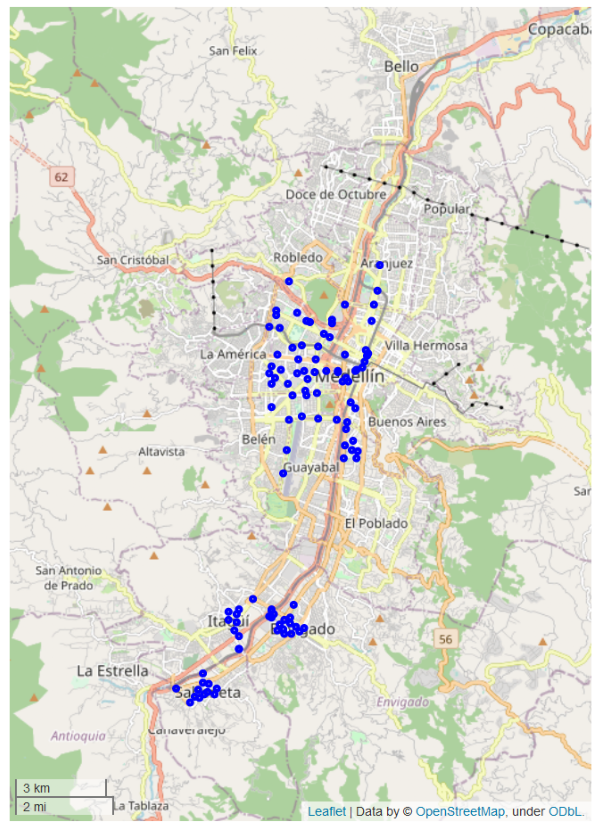

In [90]:
plt.figure(figsize=(15,15))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/stations-plot.png")
plt.imshow(a)
plt.axis('off')
plt.show()

We can see that the bike stations are roughly separated between two areas in the city.

# **Aggregating and Merging Loans Data for prediction**

Since we will be predicting the surplus of deficit of bikes after a whole day, we must perform daily aggregations of the Loans data. For that, we'll be grouping by origin and destination 

In [16]:
day_station_origin = loans.groupby(['loan_date', 'origin_id'])['loan_id'].agg('count').reset_index(name="loans_day_origin").rename(columns={'origin_id':'station_id'})
day_station_dest = loans.groupby(['loan_date', 'dest_id'])['loan_id'].agg('count').reset_index(name="loans_day_dest").rename(columns={'dest_id':'station_id'})

In [17]:
day_station = day_station_origin.merge(day_station_dest, on=['loan_date', 'station_id'])
day_station['flow'] = day_station.loans_day_dest - day_station.loans_day_origin
day_station = day_station.drop(columns=['loans_day_origin', 'loans_day_dest'])

In [18]:
day_station

,loan_date,station_id,flow
0,2014-12-31,1,-9
1,2014-12-31,2,-5
2,2014-12-31,4,-21
3,2014-12-31,6,-22
4,2014-12-31,7,-2
...,...,...,...
95939,2021-04-20,137,-7
95940,2021-04-20,139,-4
95941,2021-04-20,140,4
95942,2021-04-20,141,3


We now have the **flow** data. This is the number we'll be predicting in out model. We'll be essentially trying to predict multiple time series (one for each station).

# **Adding Features to our Time Series data**

## Lags and Diffs

Now that we have the variable we want to predict, we want to add some features to make it possible for a model to predict the daily flow for each station. There are two types of features which usually are very useful when trying to forecast time series: lags and differences.

Last-x-Day_Intensity: this is simply the amount of sales that a product had in the previous week
Last Week Diff: the difference between the amount of sales in the previous week and the week before it (t-1 - t-2)


In [19]:
time_feats = add_lags_diffs(day_station, 'loan_date', 'station_id', 'flow', 3)
time_feats.head(5)

,loan_date,station_id,flow,Previous_day_flow,Last-1_Day_flow,Last-1_Day_Diff,Last-2_Day_flow,Last-2_Day_Diff,Last-3_Day_flow,Last-3_Day_Diff
117,2015-09-18,34,24,30.0,16.0,-12.0,28.0,20.0,8.0,21.0
128,2015-09-18,67,92,81.0,69.0,-9.0,78.0,-11.0,89.0,98.0
127,2015-09-18,66,60,33.0,46.0,-8.0,54.0,-8.0,62.0,72.0
113,2015-09-18,23,62,67.0,81.0,5.0,76.0,4.0,72.0,75.0
114,2015-09-18,24,30,44.0,43.0,4.0,39.0,-20.0,59.0,70.0


## Weather Data

Since we had problems with OpenWeatherMap, we had to resort to an alternative, and we've decided to use World Weather Online historical data. This service provides averaged daily values for weather. When we were using Open Weather Map's houly time data, we did the averaging ourselves. Also, note that the provided weather values are not the same in both services (i.e. the columns of the weather dataframe are different from what we would get from OWM).

In [20]:
frequency=24
start_date = '31-DEC-2014'
end_date = '20-APR-2021'
api_key = 'b9fcd58f2ad94fcea0a175917211205'
location_list = ['Medellin']

with HiddenPrints():
    hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)

In [21]:
#weather = pd.read_csv('/content/drive/MyDrive/WDL/Medellin.csv')
weather = pd.read_csv('Medellin.csv')

Knowing this data source, we remove some columns we intitively feel won't give a lot of information to the model, such as features related to moon cycles, sunset and sunrise time, direction of wind, snow coverage (aways zero in our data) and pressure.

In [22]:
weather = weather.drop(columns=['location', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'totalSnow_cm', 'pressure', 'winddirDegree'])

We then merge this data with our 'flow' data, which has already been enriched with lags and diff features. This merged dataset includes all the features we'll use in our predictions.

In [23]:
weather_time_feats = time_feats.merge(weather, left_on='loan_date', right_on='date_time').drop(columns=['date_time'])

In [24]:
weather_time_feats.head(5)

,loan_date,station_id,flow,Previous_day_flow,Last-1_Day_flow,Last-1_Day_Diff,Last-2_Day_flow,Last-2_Day_Diff,Last-3_Day_flow,Last-3_Day_Diff,...,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,tempC,visibility,windspeedKmph
0,2015-09-18,34,24,30.0,16.0,-12.0,28.0,20.0,8.0,21.0,...,17,17,17,5,61,83,4.7,23,7,3
1,2015-09-18,67,92,81.0,69.0,-9.0,78.0,-11.0,89.0,98.0,...,17,17,17,5,61,83,4.7,23,7,3
2,2015-09-18,66,60,33.0,46.0,-8.0,54.0,-8.0,62.0,72.0,...,17,17,17,5,61,83,4.7,23,7,3
3,2015-09-18,23,62,67.0,81.0,5.0,76.0,4.0,72.0,75.0,...,17,17,17,5,61,83,4.7,23,7,3
4,2015-09-18,24,30,44.0,43.0,4.0,39.0,-20.0,59.0,70.0,...,17,17,17,5,61,83,4.7,23,7,3


# Models

In [25]:
weather_time_feats['loan_date'] = pd.to_datetime(weather_time_feats['loan_date'])

In [26]:
whole_dataset = weather_time_feats

In [27]:
cutoff_date = datetime(2021, 1, 1)
start_date = datetime(2021, 3, 1)
end_date = datetime(2021, 3, 20)

In [28]:
mean_error = []
for day in daterange(start_date, end_date):
    train = whole_dataset[(whole_dataset['loan_date'] < day) & (whole_dataset['loan_date'] > cutoff_date)]
    # validation set is only current day
    val = whole_dataset[whole_dataset['loan_date'] == day]

    # model is mean of last 3 days
    p = (val['Last-1_Day_flow'].values + val['Previous_day_flow'].values )/2
    try:
        error = rmse(val['flow'].values, p)
    except:
        print(val['flow'].values, p)
    #print(f'Day {str(day)[:10]} - Error {error}')
    mean_error.append(error)
print('Simple Baseline Mean Error = %.5f' % np.mean(mean_error))

[] []
Simple Baseline Mean Error = 9.98459


We'll now try a random forest model. Given that tree-based models will split the numerical data rather than try to perform regression-like operations, we'll keep the station_id field as an integer

In [29]:
rf_preds, rf_mdl = rf_model (n_trees = 1000)

 Random Forest Mean Error = 9.21710


We can see that the prediction from random forest are better than or baseline prediction. Given that reandom forest tends to be relatively stable across different hyperparameter selections, we'll simply increase the number of predictors (we'll experiment with more trees)

In [31]:
print('==RANDOM FOREST MODEL ==')
print(' ')
for trees in [2500, 5000]:
    print(f'Number of estimators: {trees}')
    rf_preds, rf_mdl =rf_model(n_trees = trees)
    print(' ')

==RANDOM FOREST MODEL ==
 
Number of estimators: 2500
 Random Forest Mean Error = 9.21230
 
Number of estimators: 5000
 Random Forest Mean Error = 9.21141
 


We can see he quality of our model's predictions increases with number of estimators

In [34]:
print('==LIGHTGBM MODEL ==')
print(' ')
for trees in [2500, 5000, 7000]:
    print(f'Number of estimators: {trees}')
    p, lgb_mdl = lgb_model(trees)
    print(' ')

==LIGHTGBM MODEL ==
 
Number of estimators: 2500
LightGBM Mean Error = 9.62214
 
Number of estimators: 5000
LightGBM Mean Error = 9.72125
 
Number of estimators: 7000
LightGBM Mean Error = 9.78995
 


We tend to have the best predictions using the random model. This is likely because lightgmb tends to be more sensitive to parameter selection, which hasn't been preformed here. It  is also faster to train than Random Forest, which allows us to use more estimators. For inference, we'll use the Radom Forest with the 5000 trees.

As a simple sanity check, we can see our predictions are well correlated with our actual flow values. If we had a perfect model, the graph would show a straight diagonal line.

<Figure size 288x288 with 0 Axes>

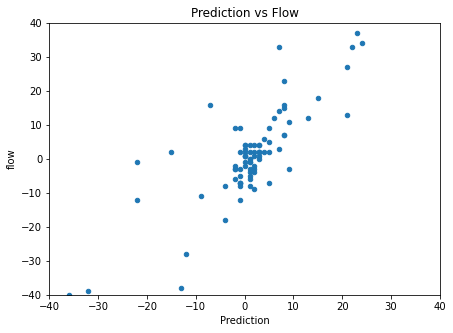

In [35]:
plt.figure(figsize=(4,4))
val.loc[:, 'Prediction'] = np.round(rf_preds)
val.plot.scatter(x='Prediction', y='flow', figsize=(7,5), title='Prediction vs Flow', ylim=(-40,40), xlim=(-40,40));

# **Inference for April 20 2021**

To calculate inference for futere days, the weather data can not be obtained from historical data sources. Open Weather Map provides a forecast function, which would normally be used. However, since the API for OSM only provided us with part of the data, we used World Weather Online, which does not provide forecasting data. Regardless, the most recent data point we have is 20 April 2021. Even if we had managed to use OWM, we would not use the forecast API in this case. Nonetheless, this point must be made clear.

In [36]:
last_day = whole_dataset[whole_dataset.loan_date == '2021-04-20']

In [39]:
last_x = last_day.drop(['flow', 'loan_date'], axis=1)
last_y = last_day['flow'].values

In [41]:
last_day_preds = rf_mdl.predict(last_x)

In [42]:
demand_pred = last_day[['station_id']]
demand_pred['net_demand'] = [int(round(d)) for d in last_day_preds]

We now have the prediction of flows for each of the stations. In order to provide specific actions (how many bikes must be transported, and to where), we'll be using station location data, which we extract from the provided dataframe.

In [43]:
demand_pred = demand_pred.merge(bike_stations[['ID', 'Lat', 'Lon']], left_on ='station_id', right_on='ID').drop(columns='ID')

In [44]:
demand_pred.head(4)

,station_id,net_demand,Lat,Lon
0,106,1,6.172641,-75.592828
1,105,8,6.174278,-75.595795
2,102,10,6.234616,-75.571961
3,101,5,6.238583,-75.586176


We can now plot the stations which had negative demand (number of bikes was reduced) in red and the stations with positive demand in green.

NOTE: Due to some issues we found when running this notebook, it may happen that the interactive graphs drawn by the **folium** library will not appear. In order to see a static version of these graphs, you can check the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing

In [45]:
pos_dem = demand_pred[demand_pred.net_demand>=0]
neg_dem = demand_pred[demand_pred.net_demand<0]

f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[6.22, -75.58],
    zoom_start=12,
    control_scale=True,
    zoom_control=False,
    min_zoom=12
    )

for i in range(len(pos_dem)):
    folium.CircleMarker([pos_dem.iloc[i]['Lat'], pos_dem.iloc[i]['Lon']], color='green', radius=2).add_to(m)

for i in range(len(neg_dem)):
    folium.CircleMarker([neg_dem.iloc[i]['Lat'], neg_dem.iloc[i]['Lon']], color='red', radius=2).add_to(m)
    
f.add_child(m)
f

NOTE: Due to some issues we found when running this notebook, it may happen that the interactive graphs drawn by the **folium** library will not appear. In order to see a static version of these graphs, you can check the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing. You can also see a static screenshot below.

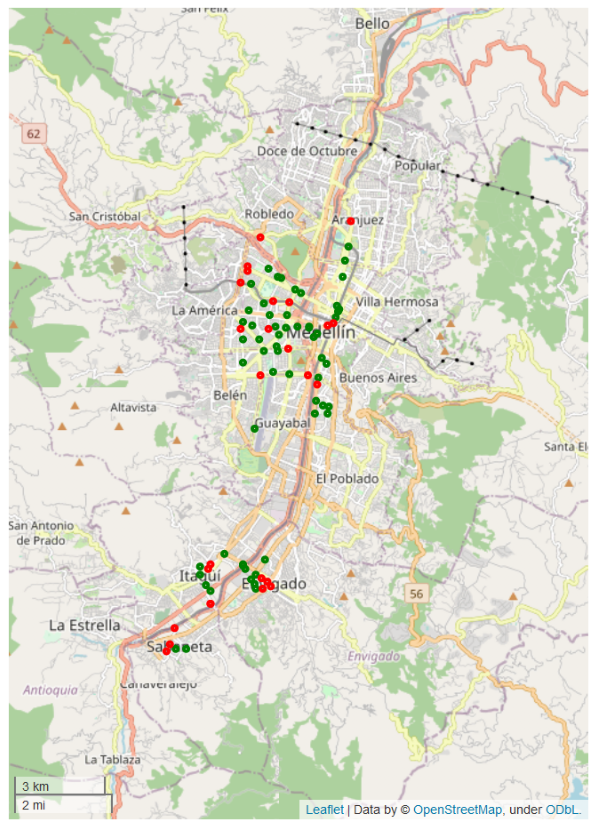

In [89]:
plt.figure(figsize=(15,15))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/flow_plot.png")
plt.imshow(a)
plt.axis('off')
plt.show()

# **Redistribution of Surplus Bicycles in each station**

Base on the daily surplus or deficit of bikes, we'll now offer actionable suggestions on the best way to move the bikes around. Distribution problems of this kind can get quite complex, and there are many ways to improve efficiency in these distributions. In our case, we'll take the distance between the stations into account (we're using haversine distance, which is a geological distance between two lattitudes and longitudes, as measured on earth's surface).

In [46]:
basic_distribute(1, demand_pred).head()

,station_id,net_demand,Lat,Lon,weightage,to_be_supplied_source,to_be_supplied_demand
8,66,-84,6.231406,-75.577222,0.197647,1,-3
14,90,-4,6.263380,-75.595092,0.009412,1,0
15,89,-71,6.246550,-75.569954,0.167059,1,-2
23,139,-4,6.174198,-75.606902,0.009412,1,0
24,137,-2,6.175772,-75.606025,0.004706,1,0


In [49]:
distribute(1, demand_pred).head()

,station_id,net_demand,Lat,Lon,distance,reciprocal_distance,demand_weightage,location_weightage,gm_weightage,weightage,to_be_supplied_source,to_be_supplied_demand
8,66,-84,6.231406,-75.577222,5.207823,0.191651,0.197647,0.044482,0.093764,0.109631,1,-1
14,90,-4,6.263380,-75.595092,3.655591,0.272807,0.009412,0.063318,0.024412,0.028543,1,0
15,89,-71,6.246550,-75.569954,3.387908,0.294299,0.167059,0.068306,0.106823,0.124899,1,-1
23,139,-4,6.174198,-75.606902,12.299203,0.081240,0.009412,0.018856,0.013322,0.015576,1,0
24,137,-2,6.175772,-75.606025,12.100601,0.082572,0.004706,0.019165,0.009497,0.011104,1,0


We can now have a matrix which describes evary bike transport, between each pair of stations. This amtrix represents our actual insight to the teams that are responsibler for moving the bikes around.

We have a matrix based on our simpler baseline:

In [57]:
basic_distribute_matrix = distribute_all_stations(basic_distribute, demand_pred)
# This baseline distribution function does not take into account location, and variation in demand

And a matrix based on our more complex distribute function, which takes more factors into account. Yhis matrix explains the movements to be made between source stations (rows) and destination stations (columns)

In [67]:
distribute_matrix = distribute_all_stations(distribute, demand_pred)
distribute_matrix.sort_values;

In [66]:
cm = sns.light_palette("green", as_cmap=True)

highlight_matrix = distribute_matrix.style.background_gradient(cmap=cm)
highlight_matrix

station_id,1,7,8,10,12,13,21,23,28,36,38,48,59,66,89,90,112,113,114,116,125,128,131,132,137,139
to_be_supplied_source,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.0,1,1,1,0,1,2,1,1,1,1,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0
6.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
9.0,0,1,1,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
11.0,0,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
19.0,0,1,1,0,1,1,1,1,0,1,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0
20.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
22.0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
24.0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


NOTE: Due to some issues we found when running this notebook, it may happen that the interactive graphs drawn by the **folium** library will not appear. In order to see a static version of these graphs, you can check the pdf at https://drive.google.com/file/d/13g87CKyTYjVgnR3VcLnpq442YYf_joxb/view?usp=sharing or the html file at https://drive.google.com/file/d/1QZVS-IsyhgRhdAiP2UHkeYHoU9mtCmAR/view?usp=sharing. You can also see a static screenshot below.

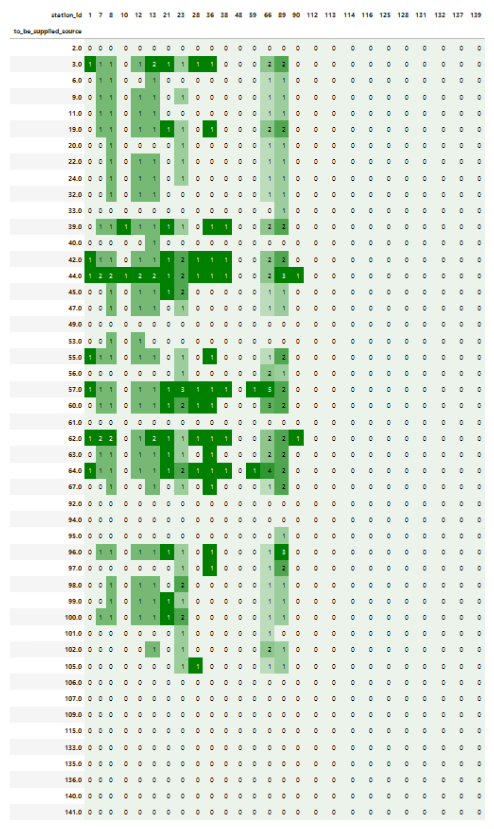

In [88]:
plt.figure(figsize=(15,15))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/matrix.png")
plt.imshow(a)
plt.axis('off')
plt.show()

In [ ]:
# As seen, this takes into consideration demand as well as location
# And keeps some for surplus stations as well, to absorb shocks

Based on this table, we can now get the highest numbers of bikes needing to be moves, and present them to the people who should move them. For now, if the number of bikes to move is less than 6, we are leaving the suggestion out.

In [68]:
max_vals_col = []
for col in basic_distribute_matrix.columns:
    max_vals_col.append(basic_distribute_matrix[col].max())

max_vals_dist=sorted(set(max_vals_col))[-5:]

for val in max_vals_dist:
    if val >=5:
        df = basic_distribute_matrix
        movements = [(df[col][df[col].eq(val)].index[i], df.columns.get_loc(col)) for col in df.columns for i in range(len(df[col][df[col].eq(val)].index))]
        for m in movements:
            print(f'Move {val} bikes from station {int(m[0])} to station {m[1]}')
    

Move 5 bikes from station 44 to station 13
Move 5 bikes from station 57 to station 13
Move 5 bikes from station 64 to station 13


## Conclusions

### Scalability and Impact
This is a very scalable solution. It could be applied to other cities with similar bike sharing programs, since it requires no data that is out of the ordinary in a system of this kind. For now, we are only using a small, recent subset of the dataset, and training small models daily. This adds some complexity, and ideally we would have a high-quality model which is changed less often.

### Future Work

 - The dynamics for Manual stations (which have people loaning out bikes) are likely very different from automatic stations. For now, we simply considered whether a station is manual as a feature, but we believe the concerns about number of bikes would be quite different in these stations, assuming they don't have a maximum fixed capacity

 - We have attempted to include elevation data for each bike station, but couldn't find an API or another source to provide the data in time. We believe this feature would offer critical insights, especially in a city with a high altitude (and likely differences in elevation) as Medellin.

 - Some additional analysis of historical data could provide insights on good ways to improve the actual infrastructure of the system, by expanding, reducing, moving, or creating new stations. This analysis would be quite fruitful.
 
 - On the same note, it would be important to cross-reference this data with information about socio-economic factors across different neighbourhoods. This way, we could make sure the system is serving disavantaged in the same way as everyone else. It would also be important to check our model's fairness in this regard, making sure e.g. it's not taking too many bikes away from poorer areas of the city.

 - When redistributing bikes across the city, every station movement, also has a fixed truck rent/fuel/driver cost. We should consideer this when making suggestions on moving bikes around.
    - We should try to make it so that trucks are as full as possible, and that distance travelled is minimized. We must also take into account the number of bikes each truck can move at at time.
    - When considering the distance travelled by the trucks, taking into account that the truck has some stations it needs to visit, this becomes a variation of the travelling salesman problem, which has been the focus of a lot of research     


- We should also present more suggestions related to the actual route to be followed when distributing the bikes, and plot it on a map. Ideally, the sugegestions would look like:
    - Drive to station 5 and pick up 10 bikes
    - Drive to station 2 and pick up 2 bikes
    - Drive to station 14 and drop 7 bikes
    - Drive to station 20 and pick up 5 bikes
    - Drive to station 8 and drop 8 bikes
    - Drive to station 20 and drop 2 bikes
    - Distribution complete  

- And it would represent the most efficient way to perform this bike distribution